In [1]:
import os
import pandas as pd
import numpy as np
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, transforms
import matplotlib.pyplot as plt
from dataloading import *
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d

%load_ext autoreload
%autoreload 2

In [2]:
plt.rcdefaults()

# Use Odd spectrograms

In [3]:
def plot_spectrogram(spec, title, time, frequency, start_longest_mode=None, end_longest_mode=None):
    fig, ax = plt.subplots()
    ax.imshow(spec.T, extent=(time[0], time[-1], frequency[0], frequency[-1]), aspect='auto', cmap='jet',
              origin='lower')
    ax.set_xlim(time[0], time[-1])
    ax.set_ylim(frequency[0], frequency[-1])
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Frequency [Hz]")
    fig.set_dpi(150)
    plt.title(title)

    # Plot vertical lines if start and end times are provided
    if start_longest_mode is not None and end_longest_mode is not None:
        ax.axvline(x=start_longest_mode, color='blue', linestyle='--', label='Start of Longest Mode')
        ax.axvline(x=end_longest_mode, color='darkblue', linestyle='--', label='End of Longest Mode')
        plt.legend(loc='upper left')

    plt.show()

In [4]:
# Example usage
DATA_PATH = "data/dataset_pickle"
FILE_EXT = "pickle"
WINDOW_SIZE = 64 # Number of datapoints
OVERLAP_FACTOR = 0.4 # Overlap factor between 0 and 1 for each sliding window ("% overlap with the last window")
TRANSFORM = True

dataset = SpectrogramDataset(data_path=DATA_PATH, file_ext=FILE_EXT, window_size=WINDOW_SIZE, overlap_factor = OVERLAP_FACTOR, transform = True)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn = custom_collate)

The size of the odd spectrogram in the last element of windows: torch.Size([2049, 64]).
Total number of windows = 6549
Number of unique IDs = 6549


torch.Size([2049, 64])


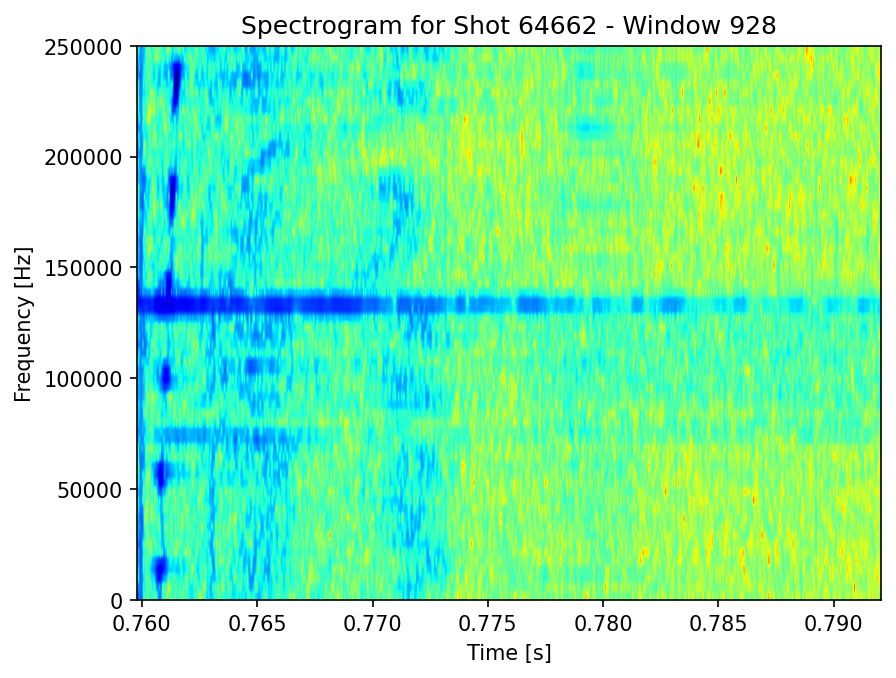

The label corresponding to this window is: 0


In [9]:
# Iterate through the dataloader
for idx, batch in enumerate(dataloader):
    #print(f"Batch {idx + 1} - Number of Windows: {len(batch)}")
    print(batch[0]['window_odd'].shape) # First item of the batch --> Very weird indexing
    plot_spectrogram(
    batch[0]['window_odd'],
    f"Spectrogram for Shot {batch[0]['shotno']} - Window {batch[0]['unique_id']}",
    batch[0]['time'],
    batch[0]['frequency']
    )
    print(f"The label corresponding to this window is: {batch[0]['label']}")
        
    break

In [14]:
# Iterate through the dataloader
for idx, batch in enumerate(dataloader):
    print(f"Batch {idx + 1} - Number of Windows: {len(batch)}")
    print(batch[0].keys()) 
    print(batch[0]['window_odd'].shape)
    print(f"The first window of the first batch has label: {batch[0]['label']}.")
    break

Batch 1 - Number of Windows: 32
dict_keys(['unique_id', 'window_odd', 'frequency', 'time', 'start_idx', 'end_idx', 'shotno', 'label'])
torch.Size([2049, 64])
The first window of the first batch has label: 0.
